# Import Resource

In [ ]:
import pickle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import roc_auc_score
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

In [ ]:
with open('/content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/data/home_credit_data.pickle', 'rb') as f:= pickle.load(f)

# Overview Statistic

## Handle Code

In [ ]:
values = {
    'Datasets': ['train_X', 'train_y', 'test_X'],
    '#observations': [train_X.shape[0], train_y.shape[0], test_X.shape[0]],
    '#features': [train_X.shape[1], 1, test_X.shape[1]]
}

data_stats = pd.DataFrame(values).set_index('Datasets')

In [ ]:
feature_names = list(train_X.columns)
print('feature_names: ', feature_names)

feature_names:  ['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MO

In [ ]:
import pandas as pd
df_count = pd.DataFrame(train_y.groupby(train_y).count())
df_count.rename(columns = {'TARGET': 'COUNT'}, inplace = True)
df_count['PERCENT'] = df_count['COUNT'].apply(lambda x: str(round(x / sum(df_count['COUNT']) * 100, 2)) + '%')
df_count['STATUS'] = ['Repaid', 'Not Repaid']

## Statistic DataFrame

In [ ]:
data_stats

,#observations,#features
Datasets,,
train_X,307511,240
train_y,307511,1
test_X,48744,240


In [ ]:
df_count

,COUNT,PERCENT,STATUS
TARGET,,,
0,282686,91.93%,Repaid
1,24825,8.07%,Not Repaid


- `train_X` is an **Imbalance** dataset
- We cannot use `accuracy` because we can train a `classifier` that predict everything is `0`, then we will get an extremely high `accuracy`, up to `91.93%`

# Handle Missing Data

In [ ]:
# Fill in empty values with the median
imputer = SimpleImputer(strategy = 'median')

imputer.fit(train_X)
train_X = imputer.transform(train_X)
test_X = imputer.transform(test_X)

# Standardize features by removing the mean and scaling to unit variance
std_scaler = StandardScaler()
std_scaler.fit(train_X)
train_X_norm = std_scaler.transform(train_X)
test_X_norm = std_scaler.transform(test_X)

# Scale each feature to 0-1
mm_scaler = MinMaxScaler(feature_range = (0, 1))
mm_scaler.fit(train_X)
train_X_mm = mm_scaler.transform(train_X)
test_X_mm = mm_scaler.transform(test_X)

# Implement baseline models

| Classifiers      | Parameter | Scaling Dataset|
| ----------- | ----------- |----------- |
| Logistic Regression|`C=1e-4, solver='lbfgs'`|train_X_norm, test_X_norm|
| SVC|`C=1e-4, max_iter=1000, gamma='auto', probability=True`|train_X_norm, test_X_norm|
| MultinomialNB|`No parameters`|train_X_mm, test_X_mm|
| MLPClassifier|`solver='adam', alpha=1e-3, activation='relu', hidden_layer_sizes=(128, 64)`|train_X_norm, test_X_norm|
| DecisionTreeClassifier|`max_depth=30`|train_X, test_X|
| GradientBoostingClassifier|`n_estimators=100, max_depth=3`|train_X, test_X|
| RandomForestClassifier|`n_estimators=50, max_depth=30`|train_X, test_X|


## Get appropriate data for different algorithms

In [ ]:
def get_train_data(classifier_name):
    """
    Get appropiate scaling data for different algorithms

    :param classifier_name: The name of the classifer

    :return: X (train set), y (train labels), X_test (test set)
    """
    y = train_y
    if classifier_name in ['Logistic_Regression', 'Neural_Network', 'SVM']:
        X = train_X_norm
        X_test = test_X_norm
    elif classifier_name == 'MultinomialNB':
        X = train_X_mm
        X_test = test_X_mm
    else:
        X = train_X
        X_test = test_X
    return X, y, X_test

## Extract and Plot Function

In [ ]:
def to_submit_file(file_name, probs):
    """
    A helper function helps generating submit files
    
    :param file_name: submit file name
    :param probs: list of probabilities for test samples
    
    :return: None
    """
    submit = test_id_df.copy()
    submit['TARGET'] = probs
    submit.to_csv(file_name, index = False)
    print('Done writting submit file: ', file_name)

In [ ]:
def plot_bar(title, x_labels, y, y_label):
    """
    A helper function helps plotting bar graphs

    :param title: title of the graph
    :param x_labels: x labels
    :param y: data for each x label
    :param y_labels: label for y-axis

    :return: None
    """
    index = np.arange(len(x_labels))
    plt.bar(index, y)
    plt.ylabel(y_label, fontsize=15)
    plt.xticks(index, x_labels, fontsize=15, rotation=90)
    plt.title(title)
    plt.show()

## Train classifers function

In [ ]:
def train_classifiers(classifier_names, classifiers, prefix_submit='/content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/Assignment 1/submits', suffix_submit='baseline'):
    """
    Train an array of classifers

    :param classifier_names: A list of classifer names
    :param classifiers: A list of scikit-learn estimators (classifers)
    :param prefix_submit: For exporting submit files
    :param suffix_submit: For exporting submit files

    :return: None
    """
    train_accuracies = []
    train_roc_auc_scores = []
    train_times = []
    test_prob_predictions = []
    
    for idx, clf in enumerate(classifiers):
        classifier_name = classifier_names[idx]

        X, y, X_test = get_train_data(classifier_name)

        print('Training for classifier: ', classifier_name)
        start_time = time.time()
        classifiers[idx].fit(X, y)
        train_time = time.time() - start_time
        print('Done training for classifer: ', classifier_name)
        
        from sklearn.metrics import roc_auc_score
        train_accuracy = classifiers[idx].score(X, y)
        train_probs = classifiers[idx].predict_proba(X)[:, 1]
        train_roc_auc = roc_auc_score(y, train_probs)
        test_probs = classifiers[idx].predict_proba(X_test)[:, 1]

        print('Train time: {} seconds'.format(train_time))
        print('Train accuracy: ', train_accuracy)
        print('Train roc auc score: ', train_roc_auc)
        print('*****************************')

        train_accuracies.append(train_accuracy)
        train_roc_auc_scores.append(train_roc_auc)
        train_times.append(train_time)
        test_prob_predictions.append(test_probs)
        
    for idx, classifer_name in enumerate(classifier_names):
        to_submit_file(
            '{}/{}_{}.csv'.format(prefix_submit, classifer_name, suffix_submit),
            test_prob_predictions[idx]
        )

    plot_bar('Train accuracies', classifier_names, train_accuracies, 'Train accuracy')
    plot_bar('Train roc_auc scores', classifier_names, train_roc_auc_scores, 'Train roc_auc')
    plot_bar('Train times', classifier_names, train_times, 'Train time')

# Create and train classifers

Training for classifier:  Logistic_Regression
Done training for classifer:  Logistic_Regression
Train time: 3.592430353164673 seconds
Train accuracy:  0.9192776843755183
Train roc auc score:  0.7450120498869429
*****************************
Training for classifier:  SVM


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Done training for classifer:  SVM
Train time: 1968.266586303711 seconds
Train accuracy:  0.6598007876141017
Train roc auc score:  0.5421828320198615
*****************************
Training for classifier:  MultinomialNB
Done training for classifer:  MultinomialNB
Train time: 0.2826666831970215 seconds
Train accuracy:  0.9150599490749924
Train roc auc score:  0.6453068655546197
*****************************
Training for classifier:  Neural_Network


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Done training for classifer:  Neural_Network
Train time: 1526.531305551529 seconds
Train accuracy:  0.9575689975317956
Train roc auc score:  0.9477238566572134
*****************************
Training for classifier:  Decision_Tree
Done training for classifer:  Decision_Tree
Train time: 44.66225051879883 seconds
Train accuracy:  0.9818868268126993
Train roc auc score:  0.9755518837105132
*****************************
Training for classifier:  Gradient_Boosting
Done training for classifer:  Gradient_Boosting
Train time: 93.51396536827087 seconds
Train accuracy:  0.9725993541694443
Train roc auc score:  0.9998105831258377
*****************************
Training for classifier:  Random_Forest
Done training for classifer:  Random_Forest
Train time: 199.13547110557556 seconds
Train accuracy:  0.9999837404190419
Train roc auc score:  0.9999999999999999
*****************************
Done writting submit file:  /content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/Assignment 1/submits/Logistic_R

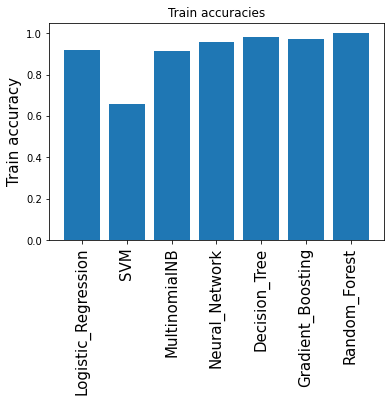

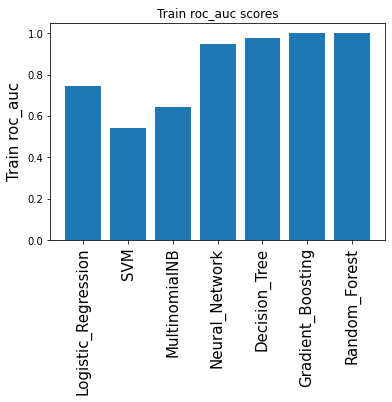

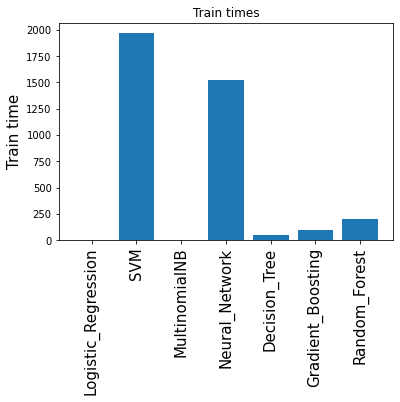

In [ ]:
classifier_names = [
    'Logistic_Regression',
    'SVM',
    'MultinomialNB',
    'Neural_Network',
    'Decision_Tree',
    'Gradient_Boosting',
    'Random_Forest',
]

classifiers = [
    LogisticRegression(C=1e-4, solver='lbfgs'),                                                              # LogisticRegression
    SVC(C=1e-4, max_iter=1000, gamma='auto', probability=True),                                              # SVC
    MultinomialNB(),                                                                                         # MultinomialNB
    MLPClassifier(solver='adam', alpha=1e-3, activation='relu', hidden_layer_sizes=(128, 64)),               # MLPClassifier
    DecisionTreeClassifier(max_depth=30),                                                                    # DecisionTreeClassifier
    RandomForestClassifier(n_estimators=50, max_depth=30),                                                   # GradientBoostingClassifier
    RandomForestClassifier(),                                                                                # RandomForestClassifier
]

train_classifiers(classifier_names, classifiers)

# Analyzing and tuning baseline models



Training for classifier:  SVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done training for classifer:  SVC
Train time: 475.81874561309814 seconds
Train accuracy:  0.9192711805431351
Train roc auc score:  0.5991163126497383
*****************************
Training for classifier:  Neural_Network
Done training for classifer:  Neural_Network
Train time: 550.8686454296112 seconds
Train accuracy:  0.9195573491679973
Train roc auc score:  0.7638583828548636
*****************************
Training for classifier:  Decision_Tree
Done training for classifer:  Decision_Tree
Train time: 26.60677433013916 seconds
Train accuracy:  0.9345291713141969
Train roc auc score:  0.7992280827796943
*****************************
Training for classifier:  Random_Forest
Done training for classifer:  Random_Forest
Train time: 33.970540046691895 seconds
Train accuracy:  0.9200906634234223
Train roc auc score:  0.9013143402899131
*****************************
Done writting submit file:  /content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/Assignment 1/submits/tuned_baseline/SVC_tuned_b

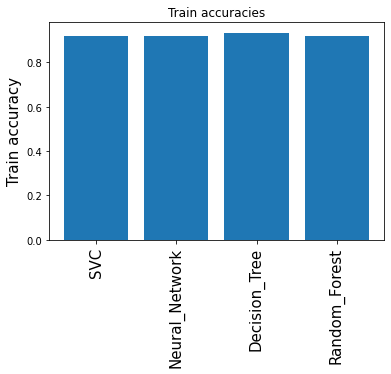

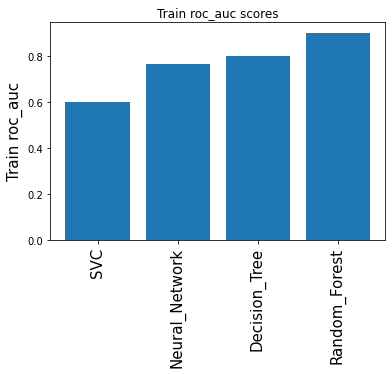

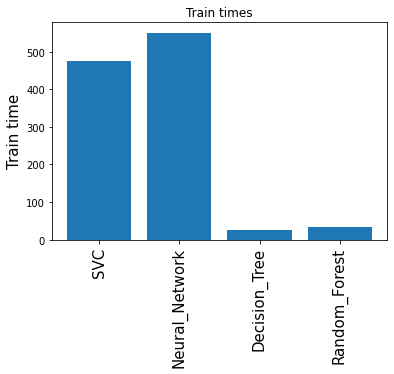

In [ ]:
tuned_classifier_names = [
    'SVC',
    'Neural_Network',
    'Decision_Tree',
    'Random_Forest',
]

tuned_classifiers = [
    CalibratedClassifierCV(cv=3),                                                            # CalibratedClassifierCV
    MLPClassifier(solver='adam', alpha=1e-1, activation='relu', hidden_layer_sizes=(128)),   # MLPClassifier
    DecisionTreeClassifier(max_depth=15),                                                    # DecisionTreeClassifier
    RandomForestClassifier(n_estimators=25, max_depth=15),                                   # RandomForestClassifier
]

train_classifiers(tuned_classifier_names, tuned_classifiers, '/content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/Assignment 1/submits/tuned_baseline', 'tuned_baseline')

# Hyper parameters tuning and  cross validation with GridSearchCV


Training for classifier:  Logistic_Regression
Done training for classifer:  Logistic_Regression
Train time: 58.52371263504028 seconds
Train accuracy:  0.9192679286269434
Train roc auc score:  0.725738560790308
*****************************
Training for classifier:  MultinomialNB
Done training for classifer:  MultinomialNB
Train time: 4.113482236862183 seconds
Train accuracy:  0.9150599490749924
Train roc auc score:  0.6453068655546197
*****************************
Training for classifier:  Neural_Network
Done training for classifer:  Neural_Network
Train time: 148.3890323638916 seconds
Train accuracy:  0.9192224018002608
Train roc auc score:  0.747393100764021
*****************************
Training for classifier:  Decision_Tree
Done training for classifer:  Decision_Tree
Train time: 300.476521730423 seconds
Train accuracy:  0.9192841882079015
Train roc auc score:  0.7124806644252849
*****************************
Training for classifier:  Gradient_Boosting
Done training for classifer: 

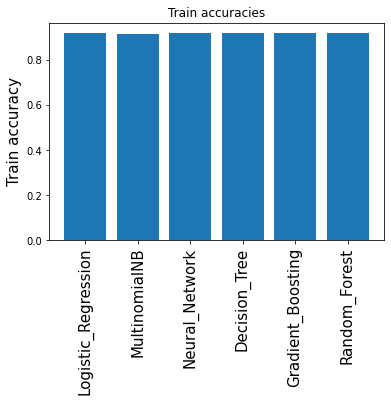

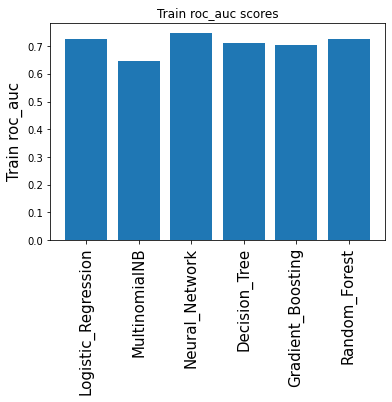

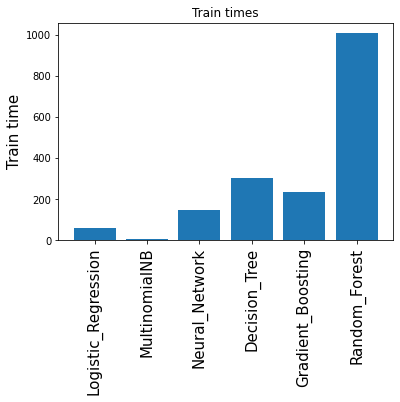

In [ ]:
cv_classifier_names = [
    'Logistic_Regression',
    'MultinomialNB',
    'Neural_Network',
    'Decision_Tree',
    'Gradient_Boosting',
    'Random_Forest',
]

tuning_parameters = [
    {
        'C': np.array([1e-3, 1e-4, 1e-5]),                                      # Logistic Regression
        'solver': ['lbfgs'],
    },
    {},                                                                         # MultinomialNB
    {
        'alpha': np.array([1e-1, 1e-2])                                         # Neural_Network
    },
    {
        'max_depth': np.array([5, 10, 20]),                                     # Decision_Tree
    },
    {
        'n_estimators': np.array([50, 100, 150]),                               # Gradient_Boosting
        'max_depth': np.array([5, 10, 20]),
    },
    {
        'n_estimators': np.array([50, 100, 150]),                               # Random_Forest
        'max_depth': np.array([5, 10, 20]),
    },
]

cv_classifiers = [
    LogisticRegression(solver='lbfgs'),
    MultinomialNB(),
    MLPClassifier(solver='adam', activation='relu',
                        hidden_layer_sizes=(128)),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
]

grid_classifiers = []
num_folds = 5

for idx, clf in enumerate(cv_classifiers):
    grid_classifiers.append(
        GridSearchCV(clf, tuning_parameters[idx], scoring='accuracy', cv=num_folds)
    )

train_classifiers(cv_classifier_names, grid_classifiers, '/content/drive/MyDrive/FUNIX Progress/MLP303x_1.1-A_EN/Assignment 1/submits/cross_validation', 'cross_validation')